In [26]:
import json
import time
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
# Models for spacy (need to run this from command line)
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_lg
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to plot word clouds
# Import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity


In [27]:
# Loading nlp model 
model = 'en_core_web_lg'
nlp = spacy.load(model)
print("Loaded model '%s'" % model)
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

Loaded model 'en_core_web_lg'


# Functions

In [28]:
def join_to_string(list):
    return ' '.join(list)

def to_text(html):
    # Converts html into text using beautifulSoup
    
    html_doc = "".join(html)
    soup = BeautifulSoup(html_doc, 'html.parser').get_text()
    
    return soup

def remove_stop_words(text):
    doc = nlp(text)
    # all tokens that arent stop words or punctuations (no lemmatization)
    words = [token.text.lower().strip()   
            for token in doc if token.lemma_.lower().strip() not in spacy_stopwords
            and token.is_punct != True
            and token.lemma_.lower().strip() != ""
            and token.lemma_ != "-PRON-"
            and token.lemma_ != "VERB"]
    #print('number of stop words =', sum([token in spacy_stopwords for token in doc]))
    return words

def extract_skills(tokens, total_skill_set):

    skill_set = set()
    for n, token in enumerate(tokens):
        if token in total_skill_set:
            skill_set.add(token)
        if n < len(tokens)-1:
            if (token + " " + tokens[n+1]) in total_skill_set :
                skill_set.add(token + " " + tokens[n+1])
        if n < len(tokens)-2:
            if (token + " " + tokens[n+1] + " " + tokens[n+2]) in total_skill_set :
                skill_set.add(token + " " + tokens[n+1] + " " + tokens[n+2])
    return skill_set

def compute_sim_matrix(column):
    # Takes a pandas series containing of strings of dimensionality n
    # Outputs a cosine similarity matrix of dimensionality n by n
    
    tfidf_vectorizer = TfidfVectorizer()
    # Tfidf matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(column)
    # cosine similarity matrix
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    print("tfidf_matrix shape is {}".format(tfidf_matrix.shape))
    print("cosine_sim_shape is {}".format(cosine_sim.shape))
    return cosine_sim

def get_location_state(text):
    # Matches US states abbreviations, if no matches looks for 
    # full state name and returns the abbreviation for it
    pattern = '([A-Za-z]+)?([\W]+)([A-Z]{2})($|[\W])'
#     pattern = '([\W])([A-Z]{2})($|[\W])'
    match = re.search(pattern, text)
    if match:
        return match.group(3)
    else:
        for key, value in states.items():
            if value in text.strip():
                return key
        # if no matches in states dict return None
        return None

def get_location_city(text):
    # Extracts city 
    
    pattern = '([A-Za-z\s\']+)?([\W]+)([A-Z]{2})($|[\W])'
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    else:
        return None

def get_location_zip(text):
    # Matches 5 digit zip code
    
    pattern = '([0-9]{5})'
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    else:
        return None

Loading json file into pandas dataframe:

In [29]:
df = pd.read_json('data_scientist_USA.json', orient='index').reset_index(drop=True)
df['description'] = df['description'].apply(join_to_string)
initial_n = df.shape[0]
print("Read in {} jobs".format(initial_n))
df['company'] = df['company'].apply(str.strip)
df['description'] = df['description'].apply(str.strip)

Read in 7538 jobs


Dropping duplicates coming from sponsored content

In [30]:
df.drop_duplicates(subset ="description", 
                     keep = False, inplace = True)
print("Dropped {} duplicates".format(initial_n - df.shape[0]))
print("Total number of job postings is {}".format(df.shape[0]))

Dropped 1669 duplicates
Total number of job postings is 5869


Dropping NaN

In [31]:
df_clean = df.dropna().reset_index()
print("Final number of job postings is {}".format(df_clean.shape[0]))
del df_clean['id']
del df_clean['index']
print(len(df_clean['company'].unique()))

Final number of job postings is 5869
2895


# Location

In [32]:
# zip codes
df_clean['zip'] = df_clean['location'].apply(get_location_zip)
print("Couldn't find zip codes for {} records".format(sum(df_clean['zip'].isnull())))

Couldn't find zip codes for 3248 records


Reading a dictionary with all american states' abbreviations

In [33]:
with open('states.json') as f:
    states = json.load(f)

In [34]:
# Pulling state abbreviations
df_clean['state'] = df_clean['location'].apply(get_location_state)
print("Couldn't find states for {} records".format(sum(df_clean['state'].isnull())))
# print(df_clean['location'][df_clean['state'].isnull()])

Couldn't find states for 3 records


In [35]:
# pulling city names 
df_clean['city'] = df_clean['location'].apply(get_location_city)
# print(df_clean['city'].unique())
# print(df_clean[['location','city','state']][df_clean['city'].isnull()])
print("Couldn't find city for {} records".format(len(df_clean[df_clean['city'].isnull()])))

Couldn't find city for 50 records


In [36]:
# # List of all american cities by state (downloaded from https://simplemaps.com/data/us-cities)
cities_list = pd.read_csv('uscities.csv')

cities = cities_list[['city', 'state_id', 'lat', 'lng', 'zips']]
merged_df = df_clean.merge(cities, how='left', left_on=['city', 'state'], right_on=['city', 'state_id'])
del merged_df['state_id']
# can also match ZIP code from scraped data where available with list of zips in cities_list

In [37]:
print("{} cities are without coordinates".format(sum(merged_df['lat'].isnull())))
merged_df.head()

537 cities are without coordinates


,company,description,link,location,title,zip,state,city,lat,lng,zips
0,Fanatics Inc.,Company Overview \n \nFanatics is the global l...,https://www.indeed.com/rc/clk?jk=abeabf216f4ea...,"San Mateo, CA",#5325 Sr. Data Scientists,None,CA,San Mateo,37.5522,-122.3122,94404 94401 94402 94403 94497
1,Vaco,"As the Data Scientist, your responsibilities i...",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Nashville, TN",$130K-$145K | Data Scientist | Contract-Hire |...,None,TN,Nashville,36.1715,-86.7843,37027 37138 37076 37072 37205 37201 37206 3724...
2,Vaco,R\n Python\n Databricks\n Scala\n Visualizatio...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Brentwood, TN 37027",$65/hr | Data Scientist/R/Python/NoSQL | Nashv...,37027,TN,Brentwood,35.9918,-86.7758,37027 37024
3,AETNA,Description: \nAetna's Medicare Business Inte...,https://www.indeed.com/rc/clk?jk=d72efc0a1d34e...,"Orlando, FL","(2) Senior Data Scientist - (Machine Learning,...",None,FL,Orlando,28.4772,-81.3369,32829 32827 32824 32822 32804 32805 32806 3280...
4,PrimeLending,Job Summary \n If you are looking to work in a...,https://www.indeed.com/rc/clk?jk=c1fcf055e91bf...,"Dallas, TX",(Mortgage) Data Scientist,None,TX,Dallas,32.7936,-96.7662,75287 75098 75233 75254 75251 75252 75253 7503...


<IPython.core.display.Javascript object>


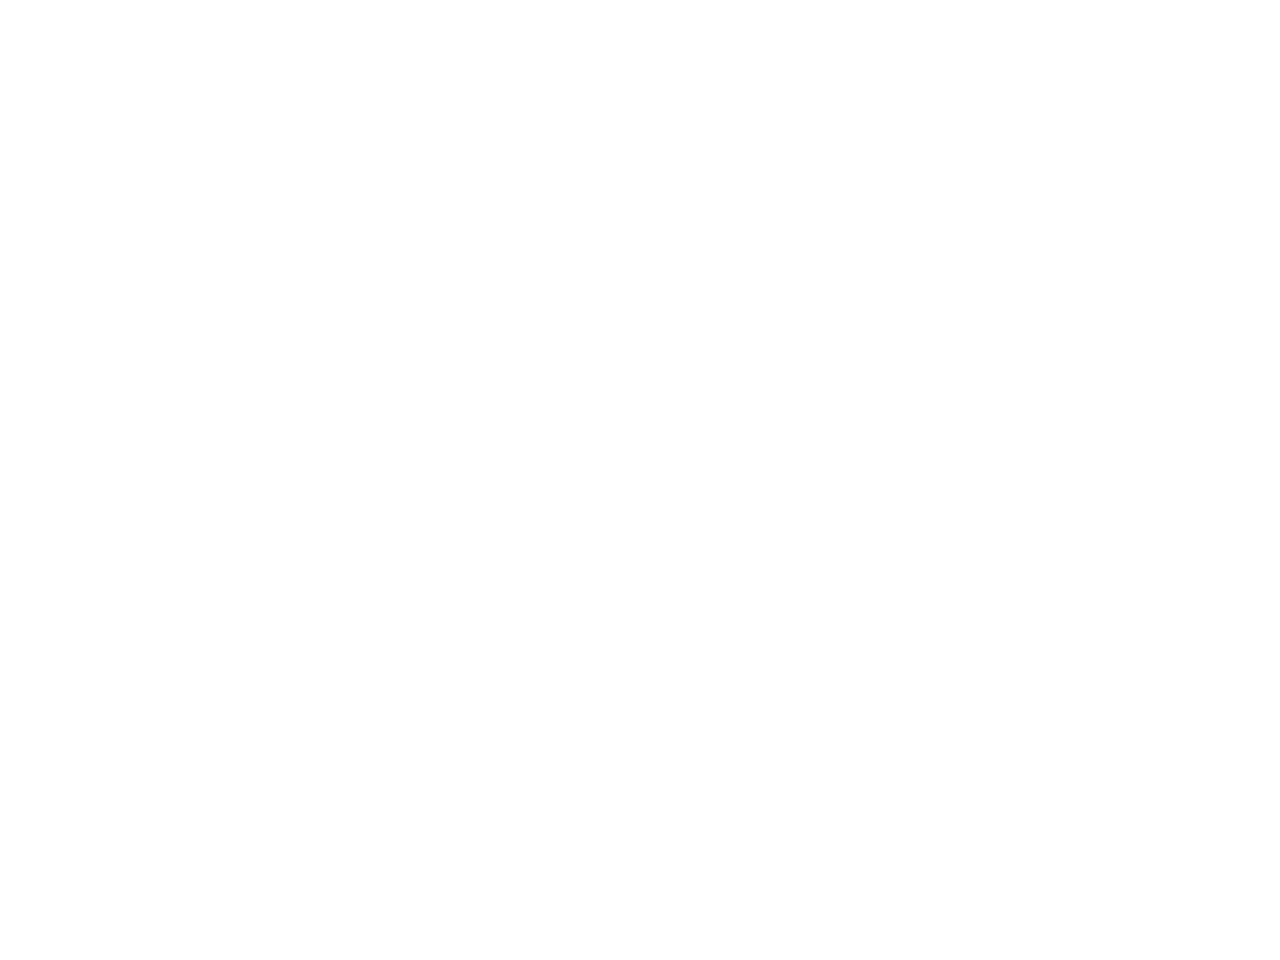

In [38]:
%matplotlib notebook
# Number of positions by state
n_pos_by_state = merged_df.groupby('state')['state'].count().sort_values(ascending=False)
# print("Top 10 states hiring in the field:\n", n_pos_by_state[:11])
n_pos_by_state[:11].plot(kind='bar')

In [39]:
%matplotlib notebook
# Number of positions by state
n_pos_by_company = merged_df.groupby('company')['state'].count().sort_values(ascending=False)
print("Top 20 companies hiring in the field:\n", n_pos_by_company[:21])
# n_pos_by_company[:11].plot(kind='bar')
# should take into account different variations of company names

Top 20 companies hiring in the field:
 company
Amazon.com Services, Inc.                177
Apple                                    109
Facebook                                  89
Booz Allen Hamilton                       52
Microsoft                                 43
Capital One - US                          41
JP Morgan Chase                           37
Amazon Web Services, Inc.                 33
Spotify                                   28
Walmart                                   25
IBM                                       24
Twitter                                   22
NVIDIA                                    19
SAIC                                      18
The Home Depot                            18
Mitre Corporation                         18
Nielsen                                   18
Johnson & Johnson Family of Companies     17
Oracle                                    17
AbbVie                                    17
Allstate                                  17
Name: st

# Skills

Here assembling a set of skills that show up in job applications, going to use it as one of the matching criteria
this list of skills is from data.world. There is still a lot of junk, should find a better option.

In [40]:
skills_new = pd.read_csv("skills.csv")
total_skill_set = set(skills_new['name'])
total_skill_set = set([skill.lower() for skill in total_skill_set])
skills_new.shape[0]

28934

Tfidf vectorizer and cosine similarity matrix

In [41]:
countvec = TfidfVectorizer(ngram_range=(1, 3), vocabulary=total_skill_set, min_df=5, max_df=0.95)
countvec.fit(merged_df['description'])
skills_vec = countvec.transform(merged_df['description'])
cosine_sim = cosine_similarity(skills_vec, skills_vec)

Creating list of skills with nonzero weight in tfidf vector

In [42]:
columns = np.asarray(countvec.get_feature_names())
skills_array = skills_vec.toarray()
skills_column = [columns[skills_array[n].astype(bool) == True] for n in range(len(skills_array))]

# adding lists of skills to dataframe 
merged_df['skills'] = skills_column
# merged_df.head()

Recommendations based on cosine similarity constructed from tfidf vector using skills vocabulary, not the whole job description. Vocabulary is trivial to modify

In [43]:
def get_recommendations(df, title, cosine_sim):
    
    # series of indices indexed by "title"
    indices = pd.Series(df.index, index=df['title']).drop_duplicates()
    # Get index of job that matches title
    idx = indices[title]
    # Sort the jobs based on the similarity scores
    scores = list(enumerate(cosine_sim[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar jobs
    scores = scores[1:21]
    # Get the indices
    job_indices = [i[0] for i in scores]
    # Return the top 10 most similar jobs
    return df['title'].iloc[job_indices]

index = 3
job = merged_df['title'][index]
rec = get_recommendations(merged_df, job, cosine_sim)
print("Recommendations for: {}\n".format(job))
for index_2, line in rec.iteritems():
    print("{}. Similarity: {}".format(line, cosine_sim[index, index_2]))


Recommendations for: (2) Senior Data Scientist - (Machine Learning, R, Python) (62398BR)

Machine Learning Modeler - CT. Similarity: 0.6448498875907215
Lead Data Scientist- 63246BR. Similarity: 0.5599149034987654
Lead Data Scientist - Clinical - 65343BR. Similarity: 0.5220372301064783
STATISTICIAN II. Similarity: 0.39982049468301833
Lead Data Scientist - 61282BR. Similarity: 0.3808017593509256
Data Scientist. Similarity: 0.35739164177580696
Data Scientist I-III. Similarity: 0.3418109115920843
Sr Data Scientist. Similarity: 0.33170332984184847
Data Scientist – Organizational Performance. Similarity: 0.33122014262265165
Data Scientist. Similarity: 0.32681068870677255
Principal Data Scientist. Similarity: 0.31922168454305044
Associate Director, Advanced Analytics & Data Science. Similarity: 0.31705516007876977
Data Scientist. Similarity: 0.3166961628456476
Sr. Dir. Data Science – Clinical Stratification - 63725BR. Similarity: 0.31616257800998465
Data Scientist (Alpharetta). Similarity: 0.

# Number of matching skills with provided resume

In [44]:
# Extracting data from resume text file
file = 'resume.txt'
with open(file) as open_file:
    resume = open_file.read().lstrip()
my_skills = extract_skills(remove_stop_words(resume), total_skill_set)
print("List of skills matched with the full list of skills:\n\n", my_skills)

List of skills matched with the full list of skills:

 {'mi', 'state', 'unix', 'physical', 'spin', 'accurate', 'international', 'professional experience', 'open source', 'ide', 'chemical', 'project', 'job scheduling', 'matplotlib', 'library', 'environment', 'high performance computing', 'metrics', 'exact', 'scipy', 'pandas', 'researchers', 'meeting', 'r', 'eclipse', 'technical', 'professional', 'writing', 'transitions', 'representation', 'courses', 'data science', 'expertise', 'ownership', 'physics', 'federal', 'git', 'scientific', 'core', 'simulations', 'education', 'dft', 'research', 'version control', 'installation', 'students', 'developing', 'group', 'poster', 'scheduling', 'hardware', 'san', 'molecular dynamics', 'publications', 'computer', 'manual', 'rates', 'electronic', 'collaboration', 'svn', 'open', 'research projects', 'software', 'performance', 'visualization', 'management', 'fortran', 'national', 'mercurial', 'designing', 'script', 'energy', 'experience', 'computation', 'p

In [45]:
# Creating list of matched skills from resume with each job posting
match_skills = []
for index, skills in enumerate(skills_column):
    overlap = my_skills.intersection(set(skills))
    match_skills.append((index, len(overlap)))
# sorting by the number of matches
sorted_skills = sorted(match_skills, key=lambda elem: elem[1], reverse=True)

# Printing top 5 jobs with largest intersection of skills
for index, n_matches in sorted_skills[:5]:
    print("\n", merged_df['title'][index])
    print(my_skills.intersection(skills_column[index]))


 Machine Learning Scientist
{'technical', 'writing', 'physical', 'unix', 'international', 'tools', 'publications', 'project', 'computer', 'expertise', 'physics', 'collaboration', 'linux', 'education', 'core', 'programming', 'management', 'national', 'scientific', 'performance', 'simulations', 'fortran', 'methods', 'systems', 'analysis', 'research', 'students', 'data analysis', 'experience', 'environment', 'projects', 'python', 'program', 'high performance computing', 'computing', 'chemistry', 'data', 'reports', 'development', 'mathematics', 'researchers', 'group', 'science'}

 Senior Data Scientist
{'professional', 'state', 'technical', 'unix', 'tools', 'professional experience', 'open source', 'courses', 'publications', 'data science', 'project', 'computer', 'physics', 'federal', 'education', 'scientific', 'management', 'national', 'open', 'performance', 'visualization', 'methods', 'systems', 'analysis', 'research', 'energy', 'data analysis', 'experience', 'environment', 'projects', 

# Education (in progress)

In [47]:
intern = ['freshman', 'sophomore', 'junior', 'internship']
higher_ed = ['bs', 'bachelor', 'bachelors', 'bachelor\'s', 'degree']
masters_degree = ['master\'s', 'masters', 'master', 'ms', 'graduate', ]
phd = ['phd', 'ph.d.', 'doctorate', 'doctoral']
def find_ed_sent(text):
    doc = nlp(text)
    for sent in doc.sents:
        for token in sent:
            if token.text.lower() in intern: print("INTERN\n", sent)
            if token.text.lower() in higher_ed: print("HIGHER ED\n", sent)
            if token.text.lower() in masters_degree: print('MASTERS\n', sent)
            if token.text.lower() in phd: print('PHD\n', sent)

find_ed_sent(to_text(df_clean['description'].iloc[36]))
# print(to_text(df_clean['description'].iloc[25]))

HIGHER ED
 Pursuing a Bachelor’s or Master’s degree in Computer Science, Analytics, Data Science, Engineering, Mathematics, or equivalent field of study
 
Graduating in Winter 2019 or Spring/Summer 2020
 
 
MASTERS
 Pursuing a Bachelor’s or Master’s degree in Computer Science, Analytics, Data Science, Engineering, Mathematics, or equivalent field of study
 
Graduating in Winter 2019 or Spring/Summer 2020
 
 
HIGHER ED
 Pursuing a Bachelor’s or Master’s degree in Computer Science, Analytics, Data Science, Engineering, Mathematics, or equivalent field of study
 
Graduating in Winter 2019 or Spring/Summer 2020
 
 
INTERN
 Preferred: 
A minimum cumulative GPA of 3.0 on a 4.0 scale
 
Previous internship or co-op participant in related industry
 
Previous internship with Phillips 66
 
Phillips 66 SHIELD Scholar recipient
 
Willing to work in any of our operating locations
 
Proficiency in R or Python and familiarity with data science packages in that language
 
Understanding of Computer Scie

# Experience (in progress)

In [48]:
def find_exp(text):
    exp_id = []
    num_id = []
    year_id = []
    sents = []
    doc = nlp(text)
    for sent in doc.sents:
        for token in sent:
            if token.text.lower() == 'experience':
                exp_id.append(token.i)
            
            if token.lemma_ == 'year':
                year_id.append(token.i)
                for token_num in doc[token.i-2:token.i]:
                    if token_num.like_num:
                        print("SENT:", sent)
                        num_id.append(token_num.i)
#     for id in exp_id: print(doc[id])
    for id in num_id: print(doc[id])
    for id in year_id: print(doc[id])
#     print(num_id)
#     print(year_id)
#     print(exp_id)
#     print(doc[337:359])

In [49]:
sent = find_exp(merged_df['description'].iloc[40])
print("\n", merged_df['description'].iloc[40])

SENT: 5+ years of SAS programming working with clinical trial data in the Pharmaceutical & Biotech industry. 

5
years

 As a leader in next generation, data-driven pharmaceutical services, Cytel is shaping the future of drug development. We deliver to the market innovative analytical software for statistical analysis and simulation, best-in-class data science analytics services and high-end impact consulting. Our culture is inclusive, collaborative and results-driven with a shared commitment to quality. With operations across North America, Europe, and India, Cytel hires passionate and talented people who share its mission of ensuring the clinical development of safe and effective medicines. 
 
We are experiencing exponential growth on a global scale and hiring Statistical Programmers to join our FSP division. You will support Phase I-IV clinical trials across a variety of therapeutic areas, and report to the Associate Director, Statistical Programming. 
 
This is a home-based positio